# Abgabe 4: Statistische Mechanik

**Teammitglieder:** René Zarwel, Matthias Kastenmüller

<br>

Importieren allgemein benötigter Bibliotheken:

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import *
import pylab as pylab
import numpy.polynomial.polynomial as poly
import numpy as np
from numpy import *
from numpy.linalg import norm
import numpy.random as rn
from scipy.integrate import odeint
import copy
import math
import random
import vpython as vp         # get VPython modules for animation
vec=vp.vector

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Aufgabe 1: Scheiben in einem Quadrat

### a) Simulation mittels Molekulardynamik

Mittels Molekulardynamik soll die Bewegung von 4 Scheiben in einem Quadrat simuliert werden. Dabei wird nicht die Bewegung selber untersucht, sondern die verschiedenen Events, die bei der Bewegung auftreten können. Dies sind Kollisionen der Scheiben mit den Wänden des Quadrates sowie die Kollisionen der Scheiben untereinander.

Um diese zu Untersuchen, wird im folgenden anhand der aktuellen Position der Scheiben die Zeitdifferenz berechnet bis zum nächsten Event. Anschließend werden die Scheiben anhand der zuvor berechneten Zeitdifferenz bewegt und die Änderung der Bewegungen durch das Event ausgeführt. Bei einer Kollision mit einer Wand wird lediglich die Bewegungsrichtung geändert, da das Modell für die Grenzen des Quadrates eine unendlich hohe Masse vorsieht. Im Gegensatz dazu wird bei einer Kollision von 2 Scheiben anhand des Richtungs- und Geschwindigkeitsvektor die Bewegung anhand des zweidimensionalen elastischen Stoßes neu berechnet. Anschließend wird die Zeit bis zum nächsten Event berechnet. 

Hierzu wurden folgende Funktionen erstellt:

* __wall_time:__ Bestimmung der Zeit bis zum nächsten Aufprall einer Scheibe an einer Wand.
* __pair_time:__ Bestimmung der Zeit bis zum nächsten Aufprall einer Scheibe mit einer der 3 anderen.
* __run:__ Ausführen von n Events anhand von gegebenen Anfangsbedingungen.

Dadurch, dass das Modell ideale elastische Stöße vorsieht, bleibt die Bewegungsenergie (kinetische Energie) zu jedem Zeitpunkt erhalten und wird nicht in innere Energie (z.B. Wärme, Deformation) umgewandelt. Um dies zu zeigen, wurde noch eine Funktion __compute_energy__ erstellt, die die kinetische Energie berechnet.

Zur Darstellung der Simulation wurde eine ___plotMD___ Funktion erstellt, die neben der Bewegung der Scheiben (Trajektorie) und dem Energieverlauf auch ein Histogramm der Positionen auf der X Achse plottet.

In [5]:
def compute_energy(x, v):
    Vkin = 0
    for i in range(len(x)):
        Vkin += 0.5*dot(v[i,:],v[i,:])
    return Vkin

def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

def run(pos, vel, sigma, n_events):
    xHist = []
    vHist = [] 
    singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
    pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    t = 0.0
    for event in range(n_events):
        xHist.append(copy.deepcopy(pos))
        vHist.append(copy.deepcopy(vel))
        wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
        pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
        next_event = min(wall_times + pair_times)
        t += next_event
        for k, l in singles: pos[k][l] += vel[k][l] * next_event
        if min(wall_times) < min(pair_times):
            collision_disk, direction = singles[wall_times.index(next_event)]
            vel[collision_disk][direction] *= -1.0
        else:
            a, b = pairs[pair_times.index(next_event)]
            del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
            abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
            e_perp = [c / abs_x for c in del_x]
            del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
            scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
            for k in range(2):
                vel[a][k] += e_perp[k] * scal
                vel[b][k] -= e_perp[k] * scal
    VKinHist = []
    xHist = array(xHist)
    vHist = array(vHist)
    for i,ti in enumerate(xHist):
        Vkin = compute_energy(xHist[i,:,:], vHist[i,:,:])
        VKinHist.append(Vkin)
    return xHist, vHist, array(VKinHist)

def plotMD(xhist, vhist, vkinHist):
    # Plot der Daten
    figure(figsize=(15,15))
    subplot(221)
    c = []
    for i in range(xhist.shape[1]):
        c.append(cm.rainbow((float(i)/xhist.shape[1])))
        plot(xhist[0,i,0], xhist[0,i,1],'o', color=c[i])
        plot(xhist[-1,i,0], xhist[-1,i,1],'s', color=c[i])
        plot(xhist[:,i,0], xhist[:,i,1], color=c[i])
    axis('equal')
    title('Trajektorien')
    xlabel('$x$')
    ylabel('$y$')
    grid(True)
    legend( [Line2D([],[], linestyle='-', color='k'),
             Line2D([],[], linestyle='', marker='o', color='k'),
             Line2D([],[], linestyle='', marker='s', color='k')],
            ["Verlauf",
             "$x(t=0)$",
             r'$x(t=t_{end})$'],
            numpoints=1)

    subplot(222)
    hist(xhist[:,:,0], color=c)
    title('Histogram')
    xlabel('$x$')
    ylabel('Anzahl')  
    
    subplot(223)
    axes = plt.gca()
    axes.set_xlim([0,len(vkinHist)])
    axes.set_ylim([0,2*max(vkinHist)])
    plot(range(len(vkinHist)), vkinHist, label='Kinetisch')
    grid(True)
    xlabel('Event')
    ylabel('Energie')
    title('Energie pro Event')
    legend()

Im Folgenden werden verschiedenen Anfangsbedinungen gewählt und die Bewegung simuliert.

Im ersten Fall werden die Scheiben gleichmäßig in dem Quadrat angeordnet und mit zufällig gewählten Anfangsgeschwindigkeiten versehen. Zusätzlich wird die Größe der Scheiben auf 0.1 gesetzt und die Simulation für 50 Events ausgeführt.

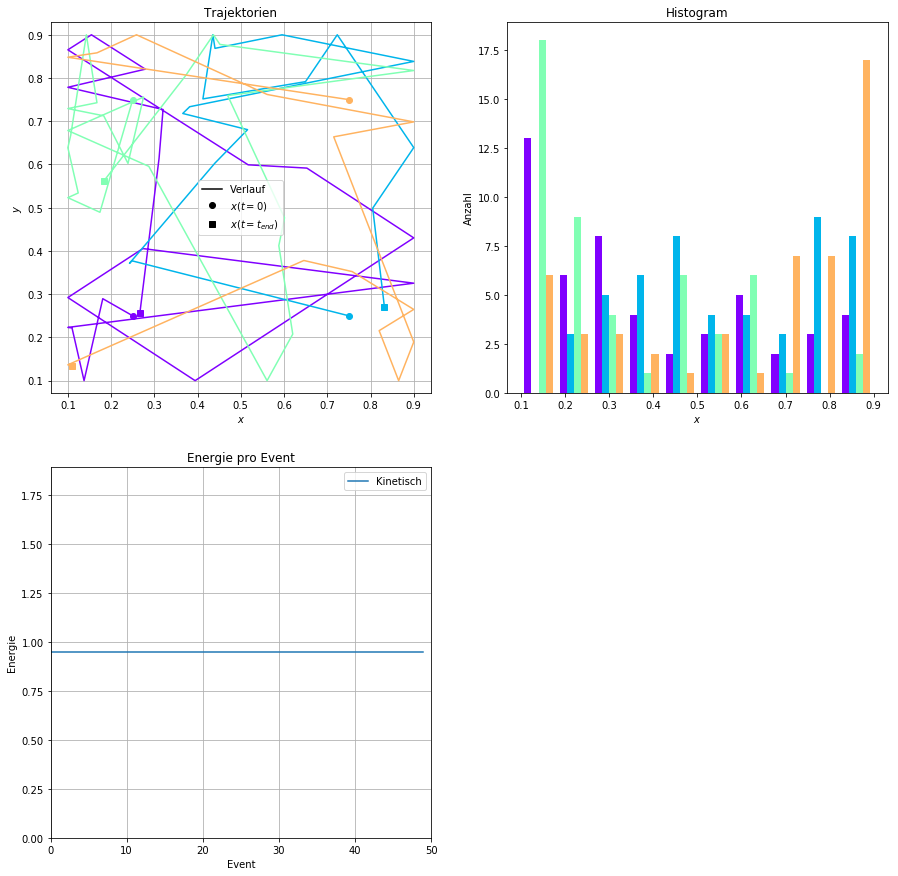

In [3]:
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[-0.21, 0.12], [-0.71, 0.18], [-0.23, -0.79], [-0.78, 0.1177]]
sigma = 0.1
n_events = 50
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

In der oben dargestellten Simulation ist ersichtlich, wie sich die Bewegungen durch die Events (Kollisionen) verändern. Dabei bleibt zum jedem Zeitpunkt die kinetische Energie erhalten. Anhand des Histograms ist ersichtlich, dass alle Scheiben sich auf der gesamten Achse bewegen. Dabei halten sie sich vermehrt am Rand des Qudrates auf, da die Wahrscheinlichkeit einer Kollision mit einer anderen Scheibe im Mittleren Bereich höher ist als am Rand.

Um dies zu verdeutlichen, wird im folgenden die Größe der Scheiben immens groß gewählt.

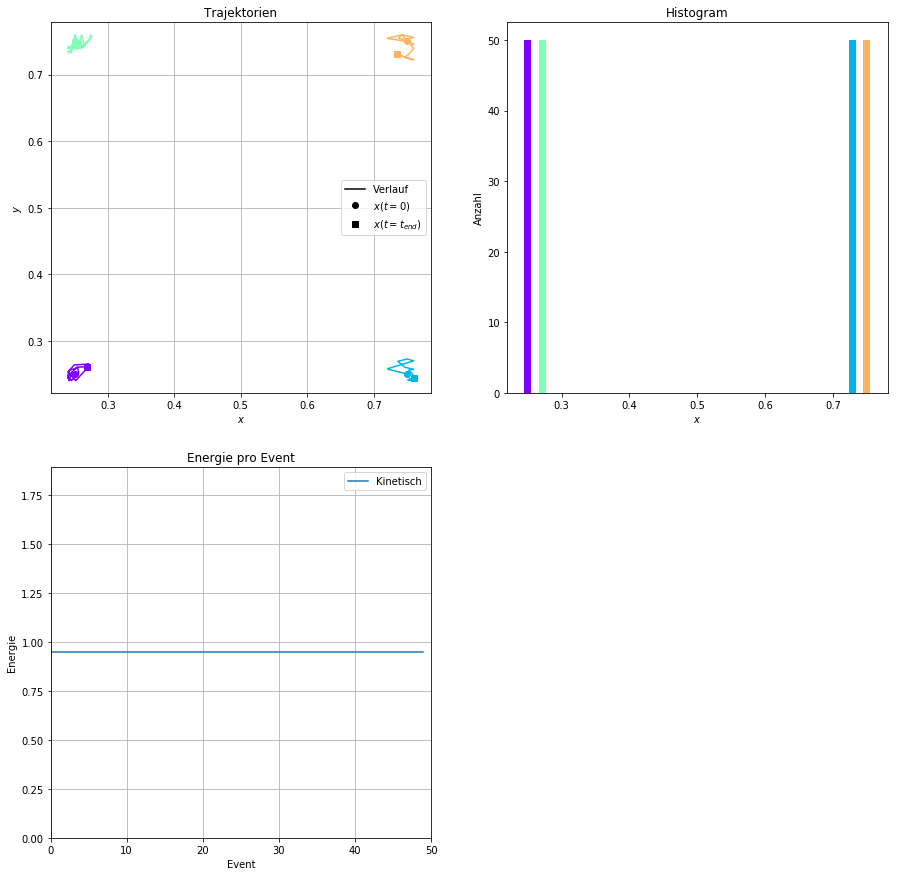

In [6]:
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[-0.21, 0.12], [-0.71, 0.18], [-0.23, -0.79], [-0.78, 0.1177]]
sigma = 0.24
n_events = 50
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

Durch die Größe der Scheiben erfolgt direkt eine Kollision mit einer anderen Scheibe, sobald dies zu weit in den mittleren Bereich kommt. Dadurch können sich die Scheiben nicht weit von ihrer Position bewegen und bleiben am Rand.

Im Folgenden wird die erste Simulation auf 10.000 Events verlängert.

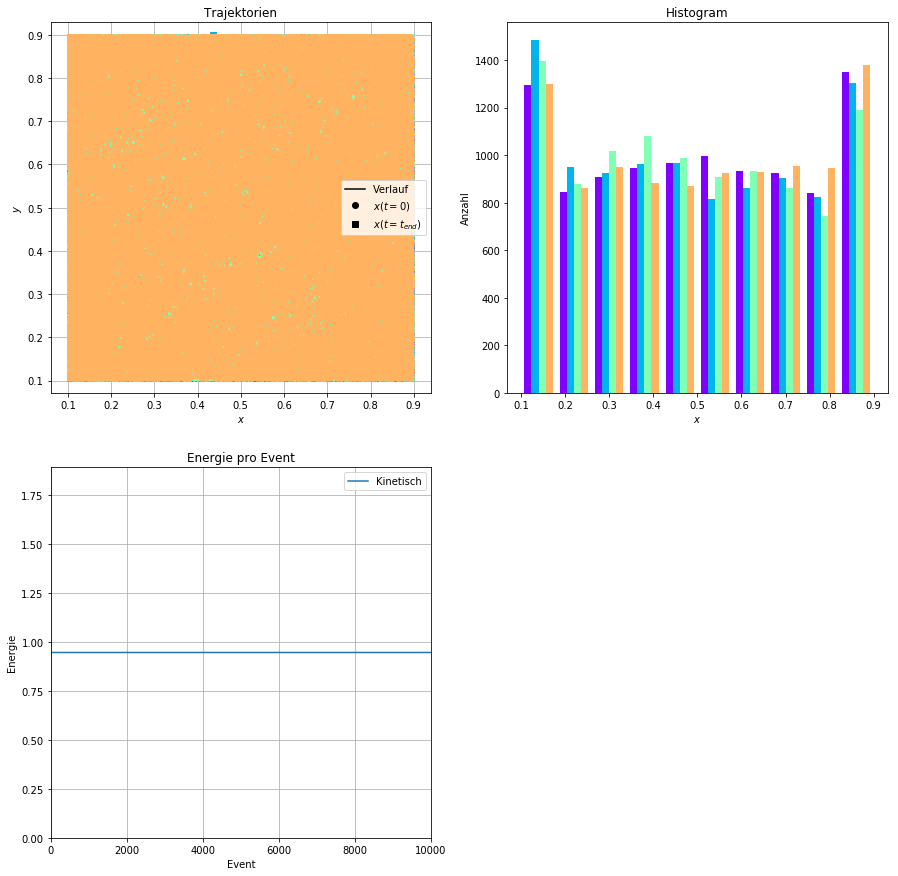

In [8]:
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[-0.21, 0.12], [-0.71, 0.18], [-0.23, -0.79], [-0.78, 0.1177]]
sigma = 0.1
n_events = 10000
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

Auch wenn die Scheiben von der Trajektorie sich im gesamten Feld bewegen, ist die Wahrscheinlichkeit eines aufenthaltes am Rand um ca. 40-50% höher.

### b) Simulation mittels Markov-Monte-Carlo-Algorithmus

Die zuvor durchgeführte Simulation soll nun mittels des Markov-Monte-Carlo-Algorithmus nachgestellt werden. Aufgrund des Gesetzes der großen Zahl, wird erwartet, dass die Positionsverteilung ähnlich der zuvor ist.

Beim Markov-Monte-Carlo-Algorithmus wird die Bewegung nicht direkt berechnet. Stattdessen wird eine zufällig gewählte Scheibe um ein zuvor definiertes Delta bewegt und anschließend überprüft, ob diese Bewegung gültig ist und akzeptiert werden kann. Eine Bewegung ist dann gültig, wenn diese im vorher definierten Quadrat stattfindet und keine Kollision erfährt.

Für die Simulation werden die gleichen Startpositionen und Größen gewählt. Damit sich die Verteilung an der realen Vertilung annähern kann, werden 1.000.000 Schritte durchgeführt.

Text(0,0.5,'Anzahl')

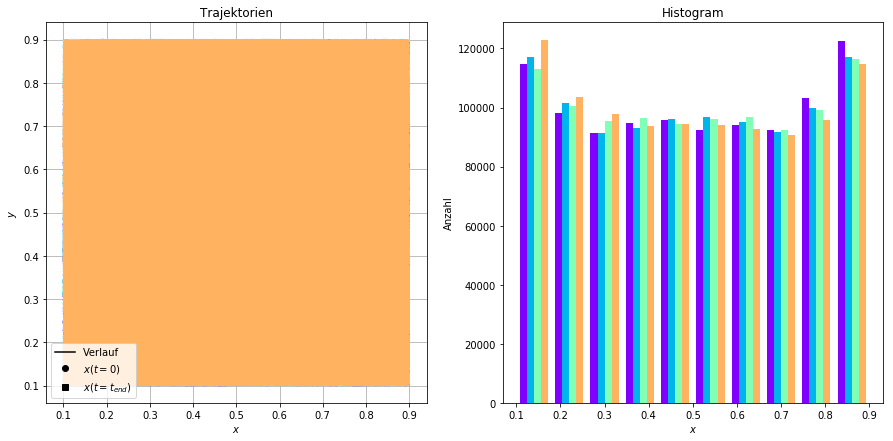

In [11]:
# Anfangsbedingungen
L = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
sigma = 0.1
sigma_sq = sigma ** 2
delta = 0.1
n_steps = 1000000
xhist = []

#Ausführung MCMC Verfahren
for steps in range(n_steps):
    a = random.choice(L)
    b = [a[0] + random.uniform(-delta, delta), a[1] + random.uniform(-delta, delta)]
    min_dist = min((b[0] - c[0]) ** 2 + (b[1] - c[1]) ** 2 for c in L if c != a)
    box_cond = min(b[0], b[1]) < sigma or max(b[0], b[1]) > 1.0 - sigma
    if not (box_cond or min_dist < 4.0 * sigma ** 2):
        a[:] = b
    xhist.append(copy.deepcopy(L))

xhist = array(xhist)
# Plot der Daten
figure(figsize=(15,7))
subplot(121)
c = []
for i in range(xhist.shape[1]):
    c.append(cm.rainbow((float(i)/xhist.shape[1])))
    plot(xhist[0,i,0], xhist[0,i,1],'o', color=c[i])
    plot(xhist[-1,i,0], xhist[-1,i,1],'s', color=c[i])
    plot(xhist[:,i,0], xhist[:,i,1], color=c[i])
axis('equal')
title('Trajektorien')
xlabel('$x$')
ylabel('$y$')
grid(True)
legend( [Line2D([],[], linestyle='-', color='k'),
         Line2D([],[], linestyle='', marker='o', color='k'),
         Line2D([],[], linestyle='', marker='s', color='k')],
        ["Verlauf",
         "$x(t=0)$",
         r'$x(t=t_{end})$'],
        numpoints=1)

subplot(122)
hist(xhist[:,:,0], color=c)
title('Histogram')
xlabel('$x$')
ylabel('Anzahl') 

Im obigen Histogramm ist ersichtlich, dass sich die Verteilung der X-Positionen an der Molekulardynamik-Simulation anpasst und auch hier ein Erhöhung in den Randbereichen aufweist.

## Aufgabe 2: Monte-Carlo-Verfahren zur Integration

Es sollen Zufallszahlen generiert werden, die einer bestimmten Verteilung entsprechen. Python bzw. numpy enthällt keinen Generator der für eine bestimmte Verteilung die anhand einer Funktion gegeben ist zufällige Werte generiert. Daher müssen zunächst gleichverteilte Zufallszahlen generiert werden, die anschließend durch eine passende Funktion so angepasst werden, dass die Zufallszahlen der gewünschten Verteilung entsprechen.

Eine solche Funktion muss die Eigenschaft haben, dass sie eine geringe Steigung an den Stellen aufweist bei denen die Zielverteilung eine hohe Dichte aufweist. Dadurch werden ein großer Bereich der gleichverteilten Zufallspunkte auf einen verhälltnismäßig kleinen Bereich abgebildet.

Daraus folgt: Es ist die Fläche der reziproken Verteilungsfunktion (im folgenden fr genannt).
Herangehensweise für die erste Verteilung:
\begin{align}
p(x)=e^{-x}\\
fr(x)=\int\!\frac{a}{e^{-x}} \, \mathrm{d}x=\int\!a e^{x} \, \mathrm{d}x
\end{align}
Der Faktor a ist zunächst unbekannt, sodass dieser bei der Integration nicht in Betracht gezogen werden muss. Man erhällt:
\begin{align}
fr(x)=\left[a e^x\right]\\
fr(x)=a e^x +b
\end{align}
Zunächst sind a und b unbekannt. Sie müssen so gewählt werden, dass sie den Wertebereich der gleichverteilten Quelle genau auf den gewünschten Zielbereich abbilden. Es wird festgelegt, dass der Quellbereich identisch zum Zielbereich 0-2 ist. Daduch lassen sich zwei Gleichungen bilden:
\begin{align}
fr(x)=a e^x +b\\
0=a e^0 +b\\
2=a e^2 +b\\
a=\frac{2}{-e^2+1}\approx+0.3130 \\
b=\frac{-2}{-e^2+1}\approx-0.3130
\end{align}
Zusammengefasst:
\begin{align}
fr(x)=\frac{2}{-e^2+1} e^x + \frac{-2}{-e^2+1}\approx0.3130 e^x -0.3130
\end{align}

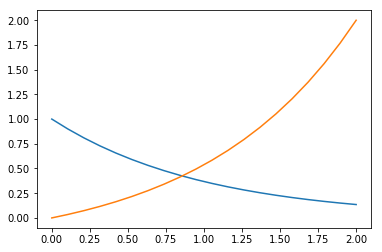

In [31]:
f1 = lambda x: math.e**-x
fr = lambda x: 0.3130*math.e**x-0.3130


plt.plot(np.linspace(0,2,20),f1(np.linspace(0,2,20)))
plt.plot(np.linspace(0,2,20),fr(np.linspace(0,2,20)))

Wie zu erkennen ist, erfüllt die Funktion fr die o.g. theoretischen Anforderungen.
Werden nun Zufallszahlen mit dieser Funktion entsprechend umgeformt, so spiegelt sich die gewünschte Verteilung im Hinstogramm wieder.

(array([249., 166., 121., 103.,  79.,  70.,  66.,  49.,  44.,  53.]),
 array([9.95474617e-04, 2.00690958e-01, 4.00386442e-01, 6.00081925e-01,
        7.99777408e-01, 9.99472892e-01, 1.19916838e+00, 1.39886386e+00,
        1.59855934e+00, 1.79825483e+00, 1.99795031e+00]),
 <a list of 10 Patch objects>)

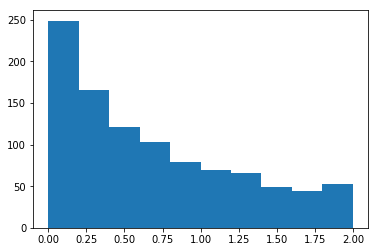

In [32]:
randVals = np.random.uniform(0, 2, 1000)
plt.hist(fr(randVals))

Es war eine weitere Verteilung gegeben. Die oben beschriebene Vorgehensweise wird dafür wiederhohlt. Aufgrund der Komplexität des Integrals wird hier numerisch vorgegangen.
Dazu wird die Fläche unter der Funktion in n Streifen unterteilt. Da hier das Intervall von 0 bis 2 angesetzt wird, hat jeder Streifen dementsprechend die Breite (x -10) / n. 

Die Fläche (F2u) erhällt man nun durch aufsummieren aller Teilflächen (Streifen):

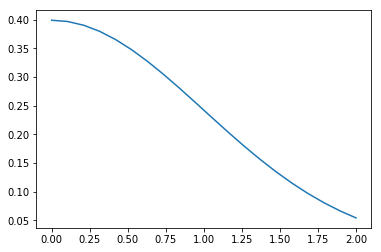

In [109]:
n = 50

f2 = lambda x: 1/(math.sqrt(2*math.pi)) * math.e**(-0.5*x**2)
f2rezi = lambda x: 1 / f2(x)
F2u = lambda x: np.sum(f2rezi(np.linspace(0.0, x, n))* ((x) / n))

plt.plot(np.linspace(0,2,20),f2(np.linspace(0,2,20)))
#plt.plot(np.linspace(0.01,2,20),[F2u(v) for v in np.linspace(0.01,2,20)])

Auch hier müssen die Grenzen mit in die Berechnung einfließen:
\begin{align}
fr2(x)=a*F2u+b
\end{align}
Da für die ursprüngliche Funktion f(0)=0 gilt, würde man beim Bilden der rezibroken Funktion an dieser Stelle durch 0 teilen. Daher wird die Untergrenze 0 ausgeschlossen. Numerisch drückt sich dieser Vorgang durch einen Wert nahe 0 aus.
Durch Einsetzen der Ober- und Untergrenze in F2u erhällt man wieder zwei Gleichungen:

In [110]:
a=(2-0) / (F2u(2)-F2u(0))
b=0-a*F2u(0)

\begin{align}
0=a\cdot0+b\\
2=a*0.652+b
\end{align}
Dementsprechend ist:
\begin{align}
b=0\\
a\approx3.068
\end{align}

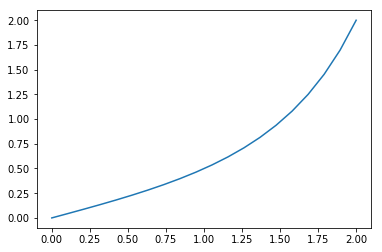

In [111]:
fr2 = lambda x: a*F2u(x)+b#2/F2u(2) * F2u(x)
plt.plot(np.linspace(0,2,20),[fr2(x) for x in np.linspace(0,2,20)])

(array([23135., 19130., 14490., 10932.,  8328.,  6737.,  5488.,  4552.,
         3838.,  3370.]),
 array([1.20254637e-05, 2.00002501e-01, 3.99992977e-01, 5.99983453e-01,
        7.99973929e-01, 9.99964405e-01, 1.19995488e+00, 1.39994536e+00,
        1.59993583e+00, 1.79992631e+00, 1.99991678e+00]),
 <a list of 10 Patch objects>)

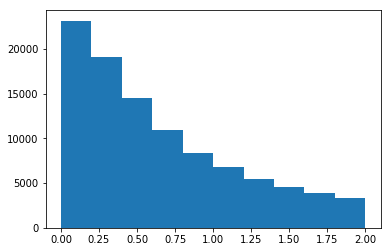

In [117]:
randVals = np.random.uniform(0, 2, 100000)
plt.hist([fr2(l) for l in randVals])

Aufgabenteil b)

Mit Hilfe des Monte-Carlo-Verfahrens soll nun das Volumen einer 10-D Kugel berechnet werden.

Dazu muss zunächst eine Strategie gefunden werden, die erkennt ob ein gegebener Punkt innerhalb oder außerhalb der Kugel liegt. Dazu kann folgende Formel verwendet werden:
\begin{align}
\vec{p}= \left( \begin{array}{c}x_1\\x_1\\...\\x_n\end{array} \right) \\
\sum\nolimits_{d=1}^Nx_d  \leq r
\end{align}
Gilt die Ungleichung, so liegt der Punkt innerhalb der Kugel. Da dieser Ansatz sehr häufig verwendet wird, wird dieser in eine Funktion ausgelagert.

In [13]:
from mpl_toolkits.mplot3d import axes3d

def inHyperkugel(v, r):
    sum = 0
    for i in v:
        sum = sum + i ** 2
    return sum <= r

Um den Ansatz nun zu validieren, wird zunächst die Fläche eines Kreises errechnet. Dazu werden n gleichverteilte Zufallszahlen generiert. Für jede wird geprüft ob sie innerhalb des Kreises liegt. Alle Treffer werden gezählt.

Von 1000 wurden 787 erkannt.


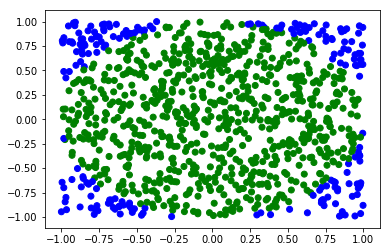

In [14]:
n = 1000
x = np.random.uniform(-1, 1, n)
y = np.random.uniform(-1, 1, n)

color = []
treffer = 0
for i in range(0,len(x)):
    color.append( 'g' if inHyperkugel([x[i], y[i]],1) else 'b')
    if inHyperkugel([x[i], y[i]],1):
        treffer = treffer + 1

plt.scatter(x,y, color=color)
print("Von " + str(n) + " wurden " + str(treffer) + " erkannt.")

Die Fläche um den Kreis die wir als Referenz heranziehen ist ein Quadrat mit der Seitenlänge 2. Nun kann über das Verhälltnis aus Treffern zur Gesamtzahl an Punkten die Fläche näherungsweise bestimmt werden.

In [15]:
A = treffer / n * (2 * 2)
print("Berechnete Fläche: " + str(A))
print("Tatsächliche Fläche: " + str(math.pi*1**2))

Berechnete Fläche: 3.148
Tatsächliche Fläche: 3.141592653589793


Näherungsweise wird das korrekte Ergebnis zurückgegeben. Zur Bestätigung wird der Vorgang für den R^3 wiederhohlt.

Berechnetes Volumen: 4.08
Tatsächliche Fläche: 4.1887902047863905


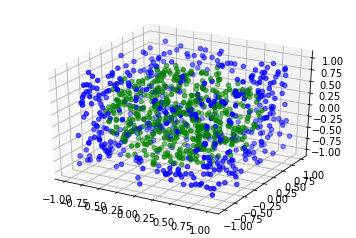

In [16]:
n = 1000
x = np.random.uniform(-1, 1, n)
y = np.random.uniform(-1, 1, n)
z = np.random.uniform(-1, 1, n)

color = []
treffer = 0
for i in range(0,len(x)):
    color.append( 'g' if inHyperkugel([x[i], y[i], z[i]],1) else 'b')
    if inHyperkugel([x[i], y[i], z[i]],1):
        treffer = treffer + 1
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=color)

A = treffer / n * (2 * 2 * 2)
print("Berechnetes Volumen: " + str(A))
print("Tatsächliche Fläche: " + str(4.0 / 3 * math.pi*1**3))

In [17]:
n = 10000
x1 = np.random.uniform(-1, 1, n)
x2 = np.random.uniform(-1, 1, n)
x3 = np.random.uniform(-1, 1, n)
x4 = np.random.uniform(-1, 1, n)
x5 = np.random.uniform(-1, 1, n)
x6 = np.random.uniform(-1, 1, n)
x7 = np.random.uniform(-1, 1, n)
x8 = np.random.uniform(-1, 1, n)
x9 = np.random.uniform(-1, 1, n)
x10 = np.random.uniform(-1, 1, n)

treffer = 0
color = []
for i in range(0,len(x1)):
    if inHyperkugel([x1[i], x2[i], x3[i], x4[i], x5[i], x6[i], x7[i], x8[i], x9[i], x10[i]],1):
        treffer = treffer + 1

print("Teffer: " + str(treffer) + " von " + str(n))
print("Würfelfläche in 10D: " + str(2**10))
print("Volumen der Kugel: " + str(2**10 * treffer / n))

Teffer: 25 von 10000
Würfelfläche in 10D: 1024
Volumen der Kugel: 2.56


Aufgabenteil c)
Nun soll mithilfe des Monte-Carlo-Verfahrens die Fläche von Funktionen bestimmt werden.
Funktion 1:

\begin{align}
f(x)=\int_0^2\!sin^2(\frac{1}{x(2-x)}) \, \mathrm{d}x
\end{align}

Auch hier muss wieder eine passende Vergleichsfläche festgelegt werden. Durch die Integralgrenzen lässt sich die x-Achse auf den Bereich 0-2 eingrenzen. Der Wertebereich des Sinus liegt zwischen -1 und 1. Dementsprechend muss der Wertebereich des Quadrates des sinus zwischen 0 und 1 liegen.
Daraus lässt sich ein Rechteck mit den Abmaßen 2x1 als Vergleichsfläche ableiten.

Für die numerische Berechnung muss beachtet werden, dass die Unter- sowie die Obergrenze nicht definiert sind. Dies würde bei der Berechnung zu einem Division-By-Zero-Fehlers führen. Daher werden Werte nahe der Grenze verwendet.

Teffer: 714 von 1000
Vergleichsfläche A: 1.9999999800000001
Errechnete Fläche: 1.42799998572


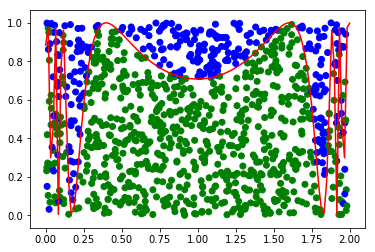

In [18]:
n=1000
upperBoundIntegral = 1.99999999
lowerBoundIntegral = 0.00000001
upperLimit = 1
lowerLimit = 0

def integral(x):
    return math.sin(1.0/(x*(2-x))) * math.sin(1.0/(x*(2-x)))

x = np.random.uniform(lowerBoundIntegral, upperBoundIntegral, n)
y = np.random.uniform(lowerLimit, upperLimit ,n)

color = []
treffer = 0
for i in range(0,len(x)):
    color.append( 'g' if integral(x[i]) >= y[i] else 'b')
    if integral(x[i]) >= y[i]:
        treffer = treffer + 1

plt.scatter(x,y, c=color)
plt.plot(np.linspace(lowerBoundIntegral, upperBoundIntegral,120), [integral (x) for x in np.linspace(lowerBoundIntegral, upperBoundIntegral,120)], c='r')

Aref = (upperBoundIntegral - lowerBoundIntegral) * (upperLimit - lowerLimit)
print("Teffer: " + str(treffer) + " von " + str(n))
print("Vergleichsfläche A: " + str(Aref))
print("Errechnete Fläche: " + str(Aref * treffer / n))

In [19]:
p=treffer/n
varianz = (p - p**2) / (n-1)
standardabw = math.sqrt(varianz / n)
print("Varianz: " +  str(varianz))
print("Standardabweichung: " +  str(standardabw))
print("Standardfehler: " +  str(standardabw / math.sqrt(n)))

Varianz: 0.00020440840840840846
Standardabweichung: 0.00045211548127487125
Standardfehler: 1.4297146862518005e-05


Nach gleichem Prinzip wird nun die Fläche des zweiten Integrals bestimmt:

Funktion 2:

\begin{align}
f(x)=\int_0^1\!\frac{x^{{-\frac{1}{2}}}}{{e^{x}+1}}) \, \mathrm{d}x
\end{align}

Teffer: 185 von 1000
Vergleichsfläche A: 3.999996
Errechnete Fläche: 0.7399992599999999


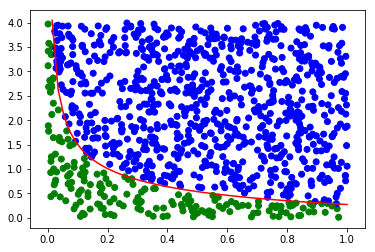

In [20]:
n=1000
upperBoundIntegral = 1
lowerBoundIntegral = 0.000001
upperLimit = 4
lowerLimit = 0

def integral(x):
    return x**(-0.5) / (math.e ** x +1)

x = np.random.uniform(lowerBoundIntegral, upperBoundIntegral, n)
y = np.random.uniform(lowerLimit, upperLimit ,n)

treffer = 0
color = []
for i in range(0,len(x)):
    color.append( 'g' if integral(x[i]) >= y[i] else 'b')
    if integral(x[i]) >= y[i]:
        treffer = treffer + 1

plt.scatter(x,y, c=color)
plt.plot(np.linspace(0.015, upperBoundIntegral,50), [integral (x) for x in np.linspace(0.015, upperBoundIntegral,50)], c='r')

Aref = (upperBoundIntegral - lowerBoundIntegral) * (upperLimit - lowerLimit)
print("Teffer: " + str(treffer) + " von " + str(n))
print("Vergleichsfläche A: " + str(Aref))
print("Errechnete Fläche: " + str(Aref * treffer / n))

In [21]:
p=treffer/n
varianz = (p - p**2) / (n-1)
standardabw = math.sqrt(varianz / n)
print("Varianz: " +  str(varianz))
print("Standardabweichung: " +  str(standardabw))
print("Standardfehler: " +  str(standardabw / math.sqrt(n)))

Varianz: 0.0001509259259259259
Standardabweichung: 0.0003884918608232686
Standardfehler: 1.2285191326386656e-05


## Aufgabe 3: Ising-Modell

Beim Ising-Modell wird eine Matrix von Spins gebildet. Dabei wird der Spin auf eins reduziert, wodurch nur zwei Zustände möglich sind ($+1$ und $-1$). Anschließend wird die Wechselwirkung der Spins untersucht. Abhängig von der Temperatur führen diese zur vollständigen Magnetisierung oder Entmagnetisierung. 

Dies soll mittels Metropolis-Monte-Carlo-Simulation modelliert und berechnet werden. Dabei wird zufällig ein Spin ausgewählt und geflipt. Anschließend wird die veränderte Energie berechnet und mit der Metropolis-Bedinung akzeptiert. Diese Bedingung beschreibt die Akzeptanz-Wahrscheinlichkeit in abhängigkeit von der Temperatur und der zuvor berechneten Energie:

$$
p_A = min(1, e^{-\frac{\Delta E}{T}})
$$

Daran ist ersichtlich, dass der neue Zustand in jedem Fall akzeptiert wird, wenn dieser energetisch gleichwertig oder günstiger ist ($\Delta E \leq 0$). Sollte der neue Zustand energetisch ungünstiger sein ($\Delta E > 0$), kann dieser mit einer gewissen Wahrscheinlichkeit $p_A$ trotzdem akzeptiert werden.

In [12]:
L = 20
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) \
                                    for i in range(N)}

def ising(T, nsteps):
    beta = 1.0 / T
    S = [random.choice([1, -1]) for k in range(N)]
    Mag = np.empty(nsteps)
    for step in range(nsteps):
        k = random.randint(0, N - 1)
        delta_E = 2.0 * S[k] * sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0, 1.0) < math.exp(-beta * delta_E):
            S[k] *= -1
        Mag[step] = sum(S)
    return Mag, S;

Im Folgenden wird das Modell für eine sehr hohe Temperatur und 3000 Schritte simuliert.

Text(0.5,1,'Ising: Hohe Temperatur')

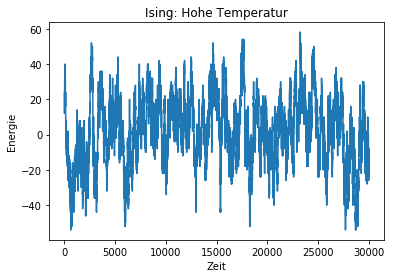

In [13]:
nsteps = 30000
T = 2000

Mag, S = ising(T, nsteps)

plot(Mag)
xlabel('Zeit')
ylabel('Energie')
title('Ising: Hohe Temperatur')

Durch die hohe Temperatur werden alle Zustände der Spins gleich wahrscheinlich und das Modell bleibt stationär um die Entmagnetisierung 0.

Nun soll die Temperatur verringert werden, wodurch sich eine Magnetisierung ausbilden sollte. 

Text(0.5,1,'Ising: Niedrige Temperatur')

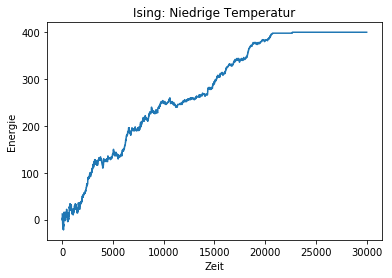

In [24]:
nsteps = 30000
T = 0.1
Mag, S = ising(T, nsteps)
plot(Mag)
xlabel('Zeit')
ylabel('Energie')
title('Ising: Niedrige Temperatur')

Durch die geringe Temperatur wird der Wahrscheinlichkeitsfaktor so gering, dass nur energetisch bessere Zustände akzeptiert werden. So entwickeln alle Spins den gleichen Zustand und das System magnetisiert sich vollständig.

Dieser Zusammenhang zwischen Temperatur und Magnetisierung wird im folgenden Plot genauer ersichtlich. Dabei werden für den Temperaturbereich von 0.1 bis 5 die Gesamtenergie des Systems nach 30.000 Schritten dargestellt.

Text(0.5,1,'Ising: Temperatur/Energie')

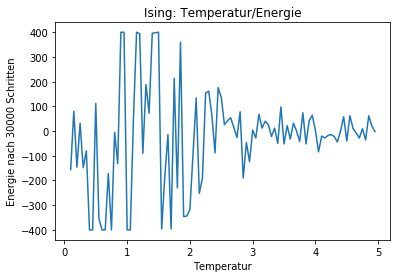

In [25]:
nsteps = 30000
temp_range = arange(0.1, 5, 0.05)
plot (temp_range, [sum(ising(temp, nsteps)[1]) for temp in temp_range])
xlabel('Temperatur')
ylabel('Energie nach ' + str(nsteps) + ' Schritten')
title('Ising: Temperatur/Energie')

Je höher die Temperatur gewählt wird, desto unwahrscheinlicher wird eine vollständige Magnetisierung.

## Aufgabe 4: Simulierte Abkühlung

Viele Optimierungsverfahren, wie das Gradientenverfahren, haben den Nachteil, dass sie nur auf ein lokales Minimum konvergieren. Im Gegensatz dazu kann mit der simulierten Abkühlung auch ein globales Minimum gefunden werden. Hierzu akzeptiert der Algorithmus mit einer gewissen Wahrscheinlichkeit auch ungünstigere Zwischenlösungen, damit das globale Minimum gefunden werden kann. Ähnlich dem zuvor beschriebenen Ising-Modell wird für die Akzeptanz die Metropolisbedingung verwendet.

Wie schon beim Verlauf des Ising-Modells bei niedriger Temperatur wird ein energetisch günstigerer Zustand gesucht. Hierzu wird eine Kostenfunktion definiert, der die Güte des aktuellen Zustandes representiert und minimiert werden muss. Im aktuellen Fall wird dies durch die zu minimierenden Funktionen direkt dargestellt.

Im nächsten Listing wird der Algorithmus als Programm ausformuliert. Dabei werden die folgenden Funktionen definiert:

* __random_neighbour:__ Zufällige Wahl eines Nachbarpunktes innerhalb des gewünschten Bereiches.
* __acceptance_probability:__ Berechnung der Akzeptanzwahrscheinlichkeit (Metropolisbedingung)
* __temperature:__ Berechnung der aktuellen Temperatur (Langsame Absenkung pro Zeitschritt).
* __annealing:__ Durchführung des Algorithmus für eine geg. Funktion.

Zusätzlich wurde die Funktion __plotAnneal__ definiert, die den Verlauf der Optimierung plottet.

In [26]:
def random_neighbour(x, interval, fraction=1):
    amplitude = (max(interval) - min(interval)) * fraction / 10
    delta = (-amplitude/2.) + amplitude * rn.random_sample()
    return max(min(x + delta, interval[1]), interval[0])


def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        return 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
        return p


def temperature(fraction):
    return max(0.01, min(1, 1 - fraction))

def annealing(start,
              cost_function,
              interval,
              maxsteps=1000):
    state = start
    cost = cost_function(state)
    states, costs = [state], [cost]
    for step in range(maxsteps):
        fraction = step / float(maxsteps)
        T = temperature(fraction)
        new_state = random_neighbour(state, interval, fraction)
        new_cost = cost_function(new_state)
        if acceptance_probability(cost, new_cost, T) > rn.random():
            state, cost = new_state, new_cost
            states.append(state)
            costs.append(cost)
    return state, states, costs

def plotAnneal(f, interval, x_end, states, costs):
    r = arange(interval[0],interval[1],0.01)
    figure(figsize=(15,7))
    subplot(121)
    plot(r, [f(x) for x in r], label='Funktion')
    plot(x_end, f(x_end), '*', markersize=10, label='Minimum')
    plot(states, costs, label='SimAnneal-Verlauf')
    xlabel('X')
    ylabel('Y')
    title('Funktionsverlauf')
    legend()
    
    subplot(122)
    plot(range(len(costs)), costs)
    
    xlabel('Event')
    ylabel('Temp.')
    title('Energieverlauf')

Im Folgenden soll die Funktion
$
f(x) = x^2 - \cos(4 \cdot \pi \cdot x)
$
minimiert werden.

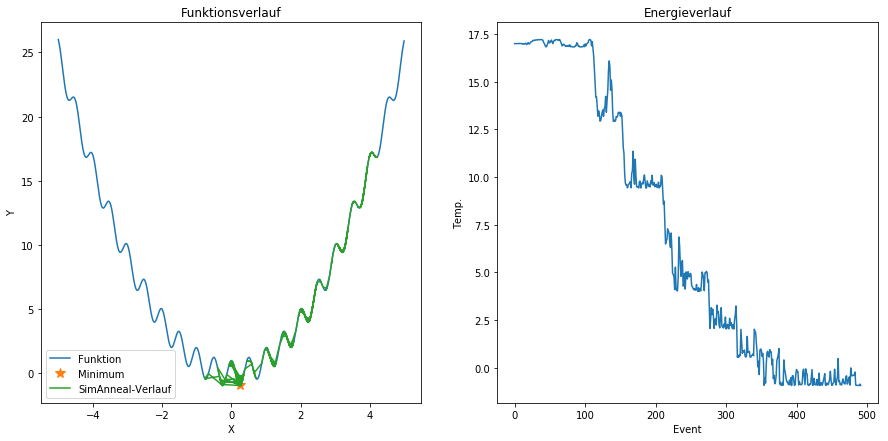

In [27]:
def f1(x, *params):
    return x**2+math.cos(4*math.pi*x)


interval = (-5, 5)
x0 = 4
x_end, states, costs = annealing(x0, f1, interval, 1000)

plotAnneal(f1, interval, x_end, states, costs)

Es ist gut ersichtlich, dass die lokalen Minima nicht akzeptiert werden und das globale Minimum schon nach ca. 400 Schritten gefunden wird. Dies ist auch am Energieverlauf ersichtlich. Dabei wird die Energie jedoch nich konstant minimiert, sondern auch, wie zuvor beschrieben, zum Finden des globalen Minimus kurzzeitig verschlechtert.

Nun soll die Funktion $f(x) = \cos(x) + \cos(\sqrt{2} \cdot x) + \cos(\sqrt{3} \cdot x)$ minimiert werden.

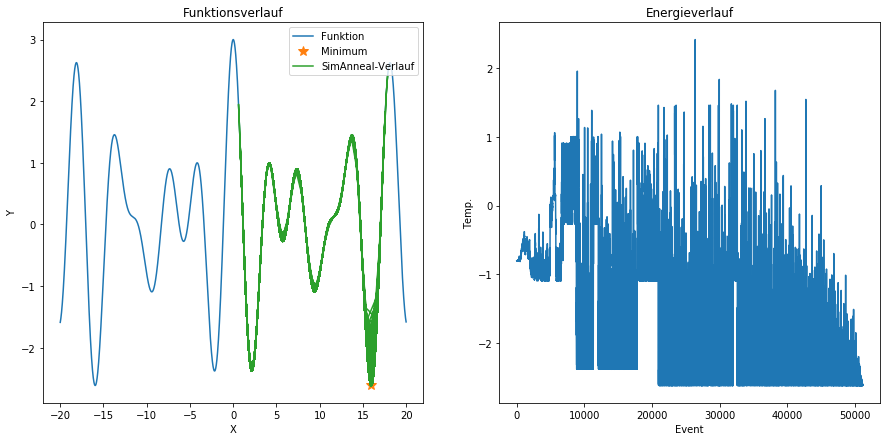

In [28]:
def f2(x, *params):
    return math.cos(x)+math.cos(math.sqrt(2)*x)+math.cos(math.sqrt(3)*x)

interval = (-20, 20)
x0 = 10
x_end, states, costs = annealing(x0, f2, interval, 100000)

plotAnneal(f2, interval, x_end, states, costs)

Da bei dieser Funktion die lokalen Minima stärker als bei der zuvorigen Funktion ausgeprägt sind, gestaltet sich die Suche nach dem globalen Minimum schwerer. So wird das globale Minimum schon nach etwa 22.000 Iteration gefunden jedoch immer wieder verworfen, bis nach ca. 52.000 dieses entgültig akzeptiert wird.
Gut ersichtlich ist auch am Energieverlauf, dass die Suche in der Nähe von lokalen Minima kurzzeitig stagniert. 